# Predicting Survival on Titanic Passenger Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn
import seaborn as sns

In [2]:
dfTitanicTrain = pd.read_csv('C:/Users/c708682/Downloads/train.csv')
dfTitanicTest = pd.read_csv('C:/Users/c708682/Downloads/test.csv')
dfTitanicFull = pd.concat([dfTitanicTrain, dfTitanicTest])

In [3]:
dfTitanicFull.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [4]:
dfTitanicFull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Missing values analysis

In [5]:
dfTitanicFull['Pclass'].isnull().sum()

0

In [6]:
dfTitanicFull['Sex'].isnull().sum()

0

In [7]:
dfTitanicFull['Age'].isnull().sum()

263

In [8]:
dfTitanicFull['SibSp'].isnull().sum()

0

In [9]:
dfTitanicFull['Parch'].isnull().sum()

0

In [10]:
dfTitanicFull['Fare'].isnull().sum()

1

In [11]:
dfTitanicFull['Cabin'].isnull().sum()

1014

In [12]:
dfTitanicFull['Embarked'].isnull().sum()

2

The numeric variable 'Age' has many missing values, which must be replaced. I replace them with the median of the corresponding passenger class group

In [13]:
med = dfTitanicFull.groupby('Pclass')['Age'].transform('median')

In [14]:
dfTitanicFull['Age'] = dfTitanicFull['Age'].fillna(med)

In [15]:
# Test again
dfTitanicFull['Age'].isnull().sum()

0

Replacing Text with Scores in Sex and Embarked:

In [16]:
# transform sex to integer

dfTitanicFull['Sex'].replace('female' , 1, inplace=True)
dfTitanicFull['Sex'].replace('male' , 0, inplace=True)

In [17]:
# transform Embarked to integer

dfTitanicFull['Embarked'].replace('S' , 0, inplace=True)
dfTitanicFull['Embarked'].replace('C' , 1, inplace=True)
dfTitanicFull['Embarked'].replace('Q' , 2, inplace=True)

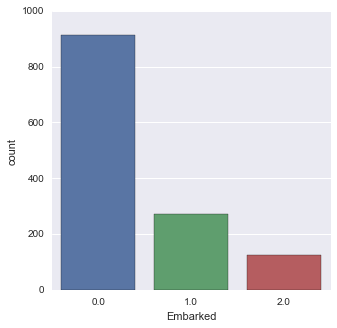

In [18]:
fig, (axis1) = plt.subplots(1,figsize=(5,5))
sns.countplot(x='Embarked', data=dfTitanicFull, ax=axis1)

In [19]:
# replacing the two missing Embarked with 0 because it's the most frequent value
dfTitanicFull['Embarked'] = dfTitanicFull['Embarked'].fillna(0)

,Embarked,Fare
0,0,27.533755
1,1,62.336267
2,2,12.409012


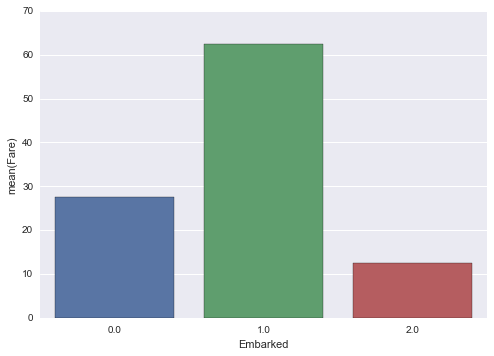

In [20]:
# calc the means of embarkement location

embark_fare = dfTitanicFull[["Embarked", "Fare"]].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x = 'Embarked', y = 'Fare', data=embark_fare)
embark_fare

In [21]:
# Finding and replacing the missing fare with the corresponding mean of the embarkemnt group
dfTitanicFull[dfTitanicFull['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,0,NaN,"Storey, Mr. Thomas",0,1044,3,0,0,NaN,3701


In [22]:
# The numeric variable 'Fare' has two missing values, which must be replaced. I replace it with the median
# of the corresponding Embarked group because fare is most likely dependent on the embarkement place
mean = dfTitanicFull.groupby('Embarked')['Fare'].transform('mean')

dfTitanicFull['Fare'] = dfTitanicFull['Fare'].fillna(mean)
dfTitanicFull[dfTitanicFull['PassengerId'] == 1044 ]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,0,27.533755,"Storey, Mr. Thomas",0,1044,3,0,0,NaN,3701


### building new variables:

Family Size could matter for survival, so we can sum up the amount of family members and after differentiate between passengers with no family member aboard at all and others:

In [23]:
dfTitanicFull['FamSize'] = dfTitanicFull['Parch'] + dfTitanicFull['SibSp'] 
dfTitanicFull['FamilyAboard'] = np.where(dfTitanicFull['FamSize'] > 0, 1, 0)

building a child variable

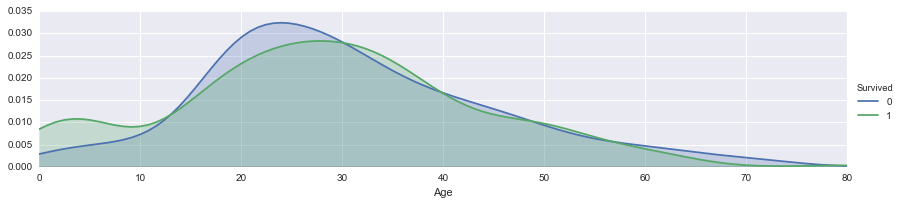

In [24]:
# I'm looking for the age, where survival rate begins to sink
facet = sns.FacetGrid(dfTitanicTrain, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, dfTitanicTrain['Age'].max()))
facet.add_legend()

In [25]:
# The relevant Age for changing the likelyhood of survival lies by Age 16
dfTitanicFull['Child'] = np.where(dfTitanicFull['Age'] < 16, 1, 0)

In [26]:
# split the data in train and test again

dfTitanicTrain = dfTitanicFull[0:890]
dfTitanicTest = dfTitanicFull[891:1309]

## Linear Regression Model


In [27]:
# Linear Regression model with all variables

from sklearn.linear_model import LinearRegression

# Remove non int vars
X_Train = dfTitanicTrain.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin' ], axis = 1)
X_Test = dfTitanicTest.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin' ], axis = 1)
Y_Train = dfTitanicTrain.Survived

Test again if there are all missing values replaced

In [28]:
X_Test.isnull().any()

Age             False
Embarked        False
Fare            False
Parch           False
Pclass          False
Sex             False
SibSp           False
FamSize         False
FamilyAboard    False
Child           False
dtype: bool

In [29]:
X_Train.isnull().any()

Age             False
Embarked        False
Fare            False
Parch           False
Pclass          False
Sex             False
SibSp           False
FamSize         False
FamilyAboard    False
Child           False
dtype: bool

linear regression with all variables:

In [30]:
lm = LinearRegression()
lm.fit(X_Train, Y_Train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
print 'Estimated Intercept Coefficient:', lm.intercept_
print 'Number of coefficients:', len(lm.coef_)
print 'R Square:', lm.score(X_Train, Y_Train)

pd.DataFrame(zip(X_Train.columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

Estimated Intercept Coefficient: 0.681881839509
Number of coefficients: 10
R Square: 0.410963772736


,features,estimatedCoefficients
0,Age,-0.003839
1,Embarked,0.033683
2,Fare,0.000400
3,Parch,-0.010811
4,Pclass,-0.165734
5,Sex,0.491779
6,SibSp,-0.028618
7,FamSize,-0.039429
8,FamilyAboard,0.089296
9,Child,0.187748


predicting survival with the test data:

In [32]:
# predictors with train data
lm.predict(X_Train)
# using these predictors on the test data  
prediction_Test = lm.predict(X_Test)


building the solution dataframe with two variables, passengerID and survived out of the test data as outcome:

In [33]:
solution = pd.DataFrame({'PassengerId' : dfTitanicTest.PassengerId, 
                         'Survived' : prediction_Test})

In [34]:
solution['Survived'] =  np.where(solution['Survived'] < 0.5, 0,1)


In [35]:
solution.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [36]:
solution.to_csv('C:/Users/c708682/Downloads/submission1.csv', sep=',', header=True, index=False)